In [7]:
# enable importing from parent directory
import os
import sys
parent_dir = os.path.split(os.getcwd())[0]
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# import other modules
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import random
import itertools
from utils import load_embeddings

In [8]:
class EmbeddingsDataset(Dataset):
    def __init__(self, embedding_dict, prompt_type="eng"):
        """
        embedding_dict: the dict with all the embeddings
        eng_prompt: if true, uses English prompting, otherwise self-prompting
        """
        self.embedding_dict = embedding_dict
        self.prompt_type = prompt_type
        self.languages = list(embedding_dict.keys())
        self.num_sencences, self.embedding_dim = embedding_dict[self.languages[0]].shape
        
    def __len__(self):
        return self.num_sencences
    
    def __getitem__(self, idx):
        """
        returns a dataset example of size (num_langs, emb_dim) which represents the embeddings of 
        the same sentence in each of the languages
        """
        return torch.stack([torch.from_numpy(self.embedding_dict[lang][idx]) for lang in self.languages])

def get_random_idx_pairs(batch_size, num_languages, num_pos_pairs, num_neg_pairs):
    """
    returns a dict with positive and negative pairs of indices (a single index is a tuple (batch_idx, lang_idx)):
    {
        "pos": [(idx1, idx2), ...],
        "neg": [(idx1, idx2), ...],
    }
    where e.g. idx1 is (batch_idx_1, lang_idx_1)
    """
    all_pos_idx_pairs = [
        ((b1, l1), (b2, l2))
        for ((b1, l1), (b2, l2))
        in list(itertools.combinations([(b, l) for b in range(batch_size) for l in range(num_languages)], 2))
        if b1 == b2
    ]
    all_neg_idx_pairs = [
        ((b1, l1), (b2, l2))
        for ((b1, l1), (b2, l2))
        in list(itertools.combinations([(b, l) for b in range(batch_size) for l in range(num_languages)], 2))
        if b1 != b2
    ]

    return {
        "pos": random.sample(all_pos_idx_pairs, num_pos_pairs),
        "neg": random.sample(all_neg_idx_pairs, num_neg_pairs),
    }

def collate_fn(embeddings):
    """
    embeddings: a tensor of size (batch_size, num_languages, embedding_dim)

    returns a tuple of:
    - a tensor of size (batch_size, embedding_dim)
    - a list of positive index pairs
    - a list of negative index pairs
    """
    embeddings = torch.stack(embeddings)
    batch_size, num_languages, _ = embeddings.shape
    idx_pairs = get_random_idx_pairs(batch_size, num_languages, num_pos_pairs=batch_size // 2, num_neg_pairs=batch_size // 2)
    pos_idx_pairs, neg_idx_pairs = idx_pairs["pos"], idx_pairs["neg"]

    output_embeddings = {}
    for ((b1, l1), (b2, l2)) in pos_idx_pairs + neg_idx_pairs:
        output_embeddings[(b1, l1)] = embeddings[b1, l1]
        output_embeddings[(b2, l2)] = embeddings[b2, l2]
    indices = list(output_embeddings.keys())
    
    # Convert index pairs
    pos_idx_pairs = [(indices.index(idx1), indices.index(idx2)) for (idx1, idx2) in pos_idx_pairs]
    neg_idx_pairs = [(indices.index(idx1), indices.index(idx2)) for (idx1, idx2) in neg_idx_pairs]
    
    return torch.stack(list(output_embeddings.values())), pos_idx_pairs, neg_idx_pairs


        

In [9]:
prompt_type = "english"
# prompt_type = "self"

# load embedding dict
embedding_dict = load_embeddings(f"../result/embedding_{prompt_type}_prompts.pkl")
num_sentences, embedding_dim = embedding_dict[list(embedding_dict.keys())[0]].shape

# define train,val,test sizes (70%, 30%)
train_size, val_size = int(num_sentences*0.7), int(num_sentences*0.3)

def get_split(embedding_dict, start_idx, end_idx):
    return {k: v[start_idx:end_idx] for k, v in embedding_dict.items()}

# make the datasets
train_set = EmbeddingsDataset(get_split(embedding_dict, start_idx=0, end_idx=train_size), prompt_type=prompt_type)
val_set = EmbeddingsDataset(get_split(embedding_dict, start_idx=train_size, end_idx=train_size + val_size), prompt_type=prompt_type)

print(f"Train size: {len(train_set)}")
print(f"Val size: {len(val_set)}")

Train size: 708
Val size: 303


In [10]:
# Define the MLP
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


In [11]:
# Define the contrastive loss
def contrastive_loss(embeddings, pos_idx_pairs, neg_idx_pairs, margin=1.0):
    pos_loss = sum(
        torch.norm(embeddings[idx1] - embeddings[idx2], p=2) ** 2
        for idx1, idx2 in pos_idx_pairs
    )

    neg_loss = sum(
        max(0, margin - torch.norm(embeddings[idx1] - embeddings[idx2], p=2)) ** 2
        for idx1, idx2 in neg_idx_pairs
    )

    return pos_loss + neg_loss / (len(pos_idx_pairs) + len(neg_idx_pairs))

In [12]:
from tqdm import tqdm

epochs = 10
batch_size = 32
save_model_path = f"../result/mlp_{prompt_type}_prompt.pt"

# make the dataloaders
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, drop_last=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, drop_last=True)

# make the MLP and optimizer
mlp = MLP(input_dim=embedding_dim, hidden_dim=embedding_dim // 2, output_dim=embedding_dim)
optimizer = torch.optim.SGD(mlp.parameters(), lr=0.001)

# training loop: 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
training_losses, val_losses = [], []
for epoch in range(1, epochs + 1):
    
    # train one epoch
    mlp.train()
    train_loss = 0.0
    for embeddings, pos_idx_pairs, neg_idx_pairs in tqdm(train_loader, desc=f"Train Epoch {epoch}"):
        optimizer.zero_grad()
        embeddings = mlp(embeddings.to(device))
        loss = contrastive_loss(embeddings, pos_idx_pairs, neg_idx_pairs)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # save training loss
    training_losses.append(train_loss / len(train_loader))

    # eval one epoch
    mlp.eval()
    val_loss = 0.0
    for (embeddings, pos_idx_pairs, neg_idx_pairs) in tqdm(val_loader, desc=f"Validation Epoch {epoch}"):
        embeddings = mlp(embeddings.to(device))
        loss = contrastive_loss(embeddings, pos_idx_pairs, neg_idx_pairs)
        val_loss += loss.item()
    
    # save val loss
    val_losses.append(val_loss / len(val_loader))

# save model
torch.save(mlp.state_dict(), save_model_path)

Validation Epoch 10: 100%|██████████| 9/9 [00:01<00:00,  4.99it/s]


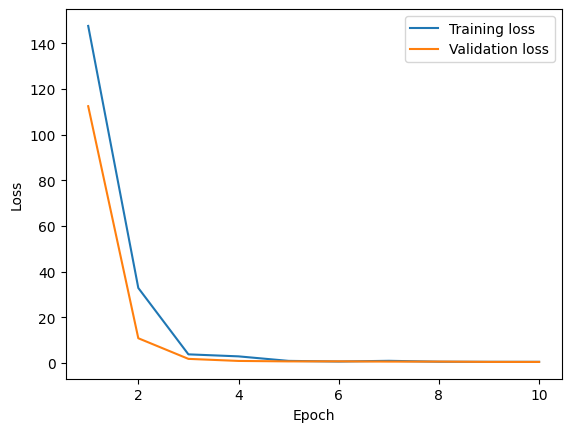

In [14]:
# Plot training and val losses over epochs
import matplotlib.pyplot as plt
plt.plot(range(1, epochs + 1), training_losses, label="Training loss")
plt.plot(range(1, epochs + 1), val_losses, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# print("Training loss: ", training_losses)
# print("Validation loss: ", val_losses)